#  Прогнозирование заказов такси

На основе исторических данных о заказах такси в аэропортах нужно спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

*Примечание: Значение метрики RMSE на тестовой выборке должно быть не больше 48.*


## Подготовка данных

Ознакомимся с данными.

In [ ]:
!pip install catboost
!pip install fast_ml -q
!pip install --upgrade scikit-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 989.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 18.2 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/datasets/taxi.csv')

data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [ ]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Датасет состоит из 26496 строк и содержит информацию о количестве заказов на определенную дату и время.

Проверим наличие пропусков.

In [ ]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Пропусков не обнаружено.

Проверим наличие дубликатов.

In [ ]:
data.duplicated().sum()

0

Дубликтаов не обнаружено.

Изменим тип данных о времени заказа на тип datetime64.

In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установим индекс таблицы равным столбцу datetime.

In [ ]:
data = data.set_index('datetime')

Отсортируем индексы таблицы в хронологическом порядке.

In [ ]:
data = data.sort_index(ascending=True)
print(data.index.is_monotonic)

True


Посмотрим период, за который представлены данные.

In [ ]:
print(data.index.max())
print(data.index.min())

2018-08-31 23:50:00
2018-03-01 00:00:00


В датасете представлены данные за период с 01 марта 2018 г. до 31 августа 2018 г.

Выполним ресемплирование данных по одному часу.

In [ ]:
data = data.resample('1H').sum()

**Вывод**  
В процессе подготовки тип данных о времени заказа был изменен на тип datetime64. Индекс таблицы был установлен равным столбцу datetime. Также индексы таблицы были отсортированы в хронологическом порядке. Было определено, что в датасете представлены данные за период с 01 марта 2018 г. до 31 августа 2018 г. Кроме того, было произведено ресемплирование данных по 1 часу, агрегация проведена с помощью метода sum().

## Анализ

Посмотрим, как меняются наши данные на протяжении всего временного ряда.

<Axes: xlabel='datetime'>

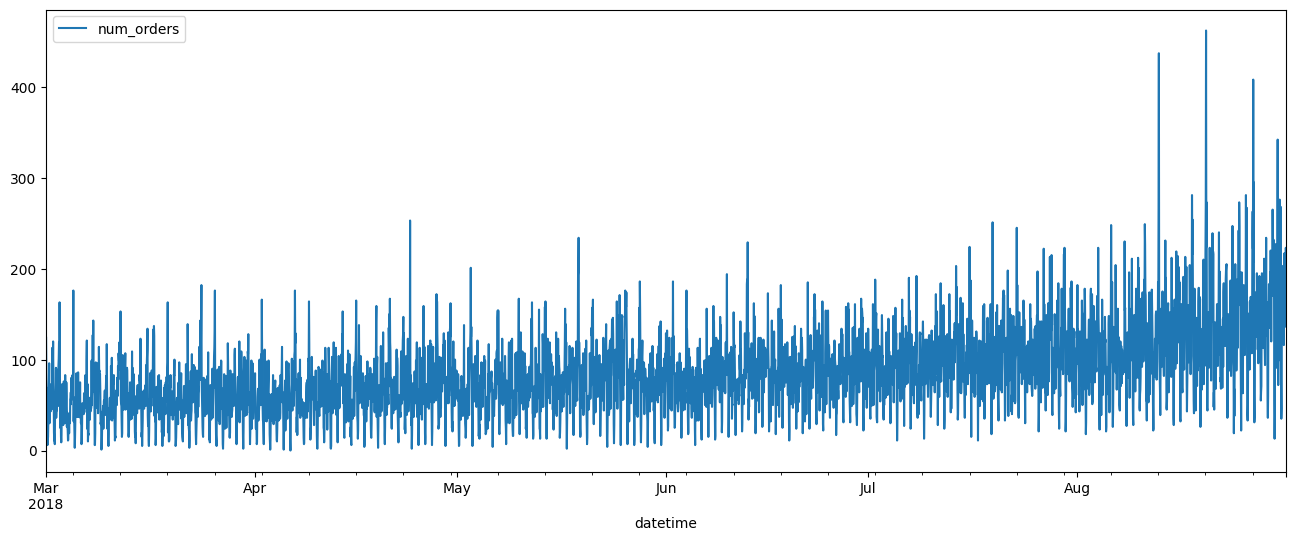

In [ ]:
plt.figure(figsize=(16, 6))
data.plot(ax=plt.gca())

Наблюдается увеличение количества заказов такси в летние месяцы, что скорее всего связано с сезоном отпусков.

Разложим данные на три составляющие: тренд, сезонность и остаток.

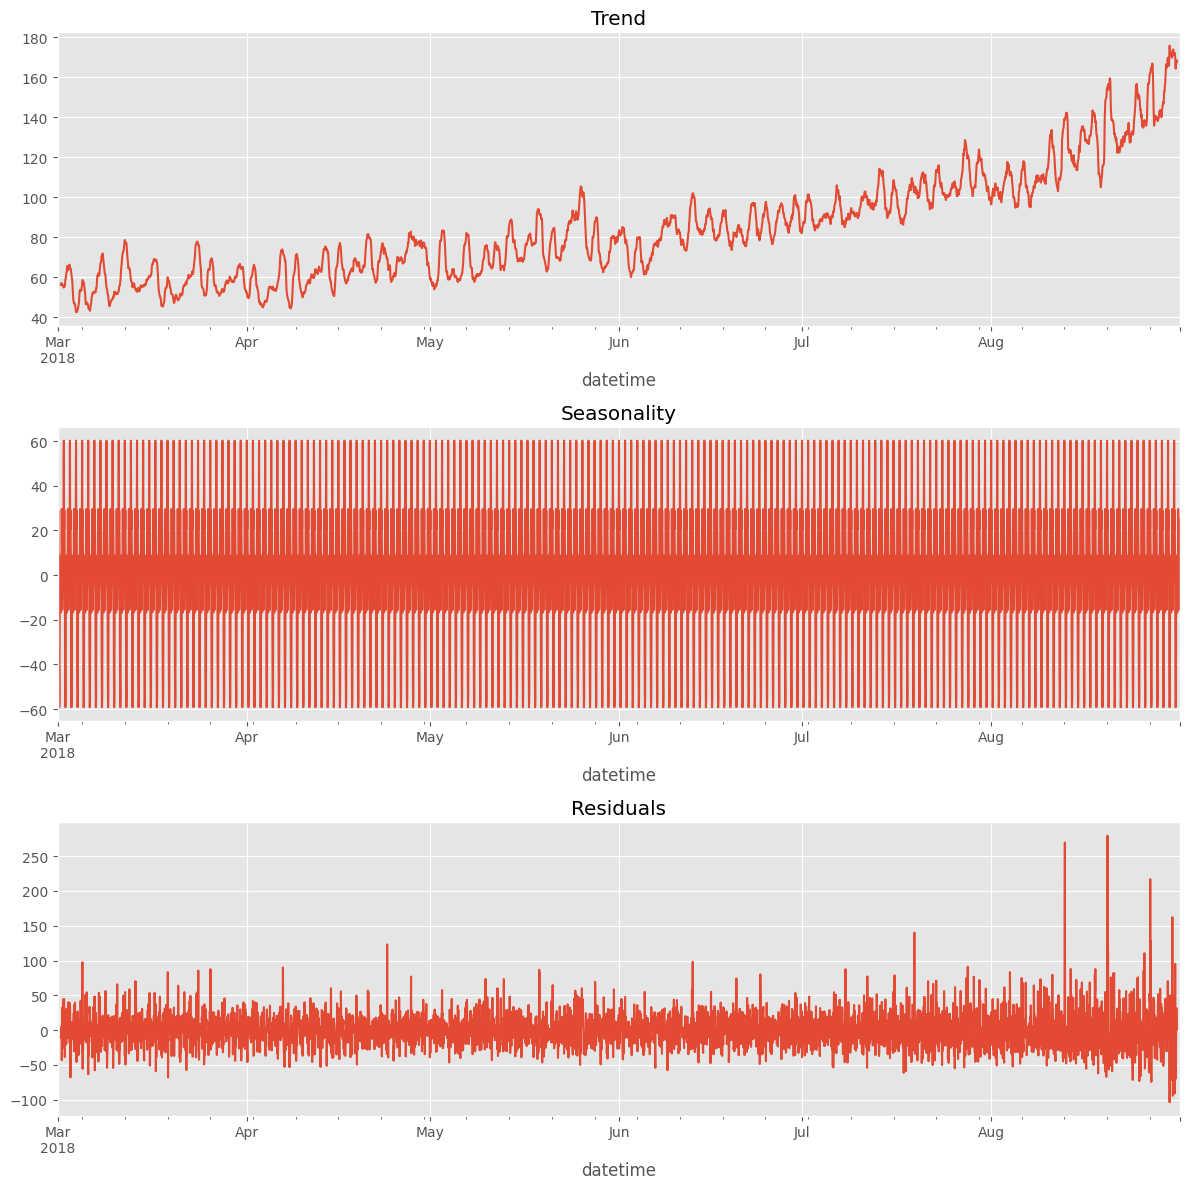

In [ ]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Построим графики последнего месяца временного ряда и проанализируем данные.

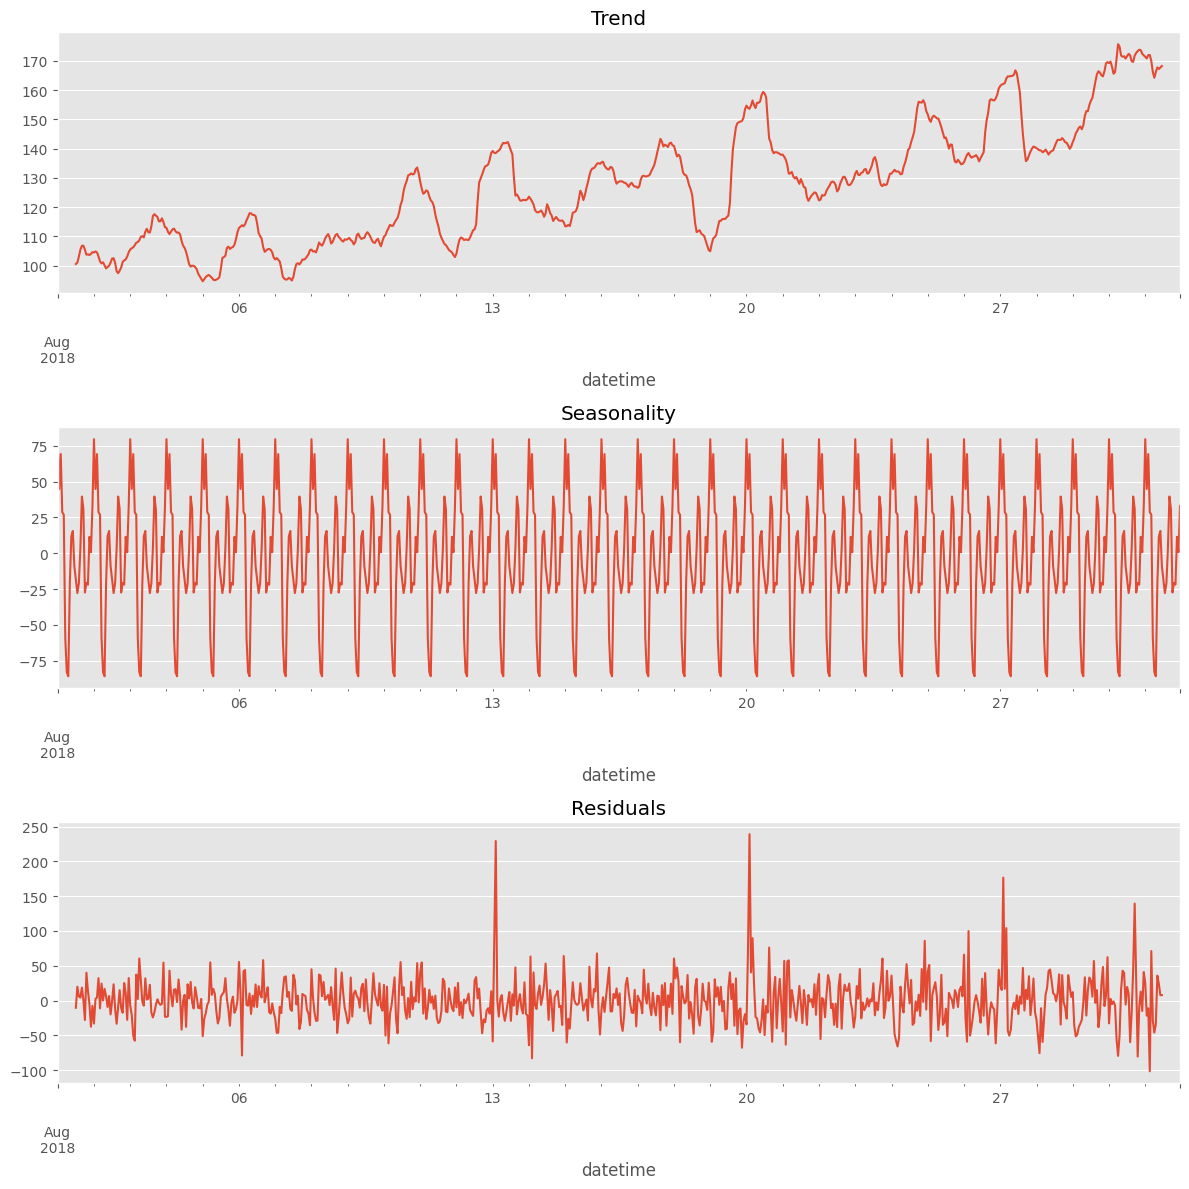

In [ ]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(data['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Наблюдается увеличение количества заказов к концу месяца.

Для более точной оценки стационарности применим тест Дики-Фуллера (Dickey-Fuller test). Используем пороговое значение, равное 0,01 (1%).   
В данном случае гипотезы звучат следующим образом:

- Нулевая гипотеза предполагает, что процесс нестационарный
- Альтернативная гипотеза соответственно говорит об обратном

In [ ]:
result = adfuller(data['num_orders'])

print("ADF статистика:", result[0])
print("p-value:", result[1])
print("Лаги:", result[2])
print("Наблюдения:", result[3])
print("Критические значения:", result[4])
for key, value in result[4].items():
    print(f"Критическое значение {key}: {value}")
print("Результат теста:", "Стационарный" if result[1] < 0.01 else "Нестационарный")

ADF статистика: -3.0689242890279504
p-value: 0.028940051402613316
Лаги: 30
Наблюдения: 4385
Критические значения: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
Критическое значение 1%: -3.431842162413052
Критическое значение 5%: -2.8621993540813637
Критическое значение 10%: -2.567120978470452
Результат теста: Нестационарный


Ряд является неcтационарным, p_value < 0.01.

## Обучение моделей

Создадим признаки для горизонта прогнозирования. Для этого напишем функцию, которая будет создавать:

- Календарные признаки - год, месяц, день, день недели.
- Отстающие значения - предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться.
- Скользящее среднее - скользящее среднее, как признак, задаст общий тренд временного ряда.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

In [ ]:
data_new = make_features(data, 100, 20)

Разобъем данные на тренировочную и тестовую выборки.

In [ ]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Поскольку мы работаем с временными рядами, вместо обычной кросс-валидации воспользуемся TimeSeriesSplit.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

Обучим модель линейной регрессии.

In [ ]:
model_lr = LinearRegression()
score = cross_val_score(model_lr, features_train, target_train, cv=tscv, scoring= "neg_mean_squared_error")
print("RMSE: %.3f" % np.mean(np.sqrt(abs(score))))

RMSE: 24.242


Обучим модель Lasso Regression.

In [ ]:
model_lasso = Lasso(alpha=1.0)
scores = cross_val_score(model_lasso, features_train, target_train, cv=tscv, scoring= "neg_mean_squared_error", n_jobs=-1)
print("RMSE: %.3f" % np.mean(np.sqrt(abs(scores))))

RMSE: 23.852


Обучим модель Random Forest. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
parameters = {'n_estimators': [est for est in range(1, 50)],
           'max_depth': [depth for depth in range(1, 20)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}
model_rf = RandomizedSearchCV(RandomForestRegressor(random_state = 12345), param_distributions=parameters, cv = tscv,
                         verbose=True, scoring="neg_mean_squared_error")
model_rf.fit(features_train, target_train)
predictions_rf = model_rf.predict(features_train)
print("RMSE: %.3f" % mean_squared_error(target_train, predictions_rf)**0.5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RMSE: 13.017


Обучим модель LightGBM. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
param_dist = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 300],
    'max_depth': [5, 10, 20],
    'min_data_in_leaf': [10, 30]
}
model_lgb = lgb.LGBMRegressor()
lgbr = RandomizedSearchCV(model_lgb, param_distributions=param_dist, n_iter=10, n_jobs = -1, cv=tscv, random_state=12345)
lgbr.fit(features_train, target_train)
predictions_lgbr = lgbr.predict(features_train)
print("RMSE: %.3f" % mean_squared_error(target_train, predictions_lgbr)**0.5)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19068
[LightGBM] [Info] Number of data points in the train set: 3874, number of used features: 105
[LightGBM] [Info] Start training from score 78.854156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Обучим модель CatBoost. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
parameters_cat = {
                   'learning_rate': [0.01, 0.1, 1],
                   'n_estimators': [50, 100, 300],
                   'max_depth': [5, 10, 20],
                   'min_data_in_leaf': [10, 30]
}
model_cat = CatBoostRegressor(verbose=False)
cat = RandomizedSearchCV(model_cat, param_distributions=parameters_cat, n_iter=10, n_jobs = -1, cv=tscv, random_state=12345)

cat.fit(features_train, target_train)
predictions_cat = cat.predict(features_train)
print("RMSE: %.3f" % mean_squared_error(target_train, predictions_cat)**0.5)

RMSE: 13.597


**Вывод**   
Были обучены пять моделей: LinearRegression,  Lasso, Random Forest, LightGBM и CatBoost. Лучшее значение метрики RMSE показала модель LightGBM, её и проверим на тестовой выборке.

## Тестирование модели

Проверим модель LightGBM на тестовой выборке.

In [ ]:
predictions_test = lgbr.predict(features_test)
print("RMSE: %.3f" % mean_squared_error(target_test, predictions_test)**0.5)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE: 38.218


Значение метрики RMSE на тестовой выборке меньше 48.    

In [ ]:
predictions_test = pd.Series(lgbr.predict(features_test), index = target_test.index, name='preds')

data_predictions = pd.concat([target_test, predictions_test], axis=1)
data_predictions.head(10)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,num_orders,preds
datetime,,
2018-08-13 14:00:00,102,84.849945
2018-08-13 15:00:00,175,128.537434
2018-08-13 16:00:00,144,166.580958
2018-08-13 17:00:00,152,138.091361
2018-08-13 18:00:00,104,110.852410
2018-08-13 19:00:00,91,100.213366
2018-08-13 20:00:00,82,87.633116
2018-08-13 21:00:00,160,122.654200
2018-08-13 22:00:00,104,117.278276


<Axes: xlabel='datetime', ylabel='num_orders'>

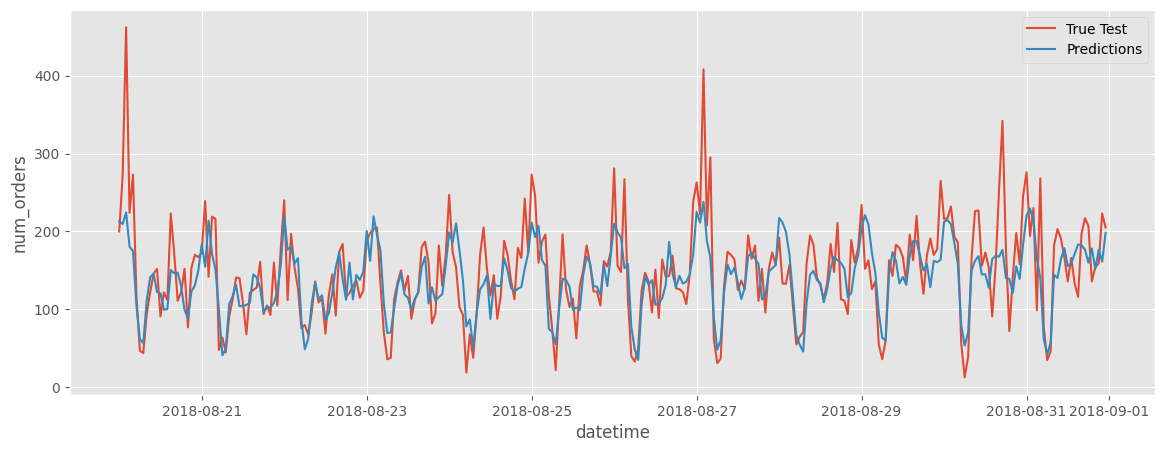

In [ ]:
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
data_plt = data_predictions['2018-08-20':]
sns.lineplot(x=data_plt.index, y=data_plt['num_orders'], label='True Test')
sns.lineplot(x=data_plt.index, y=data_plt['preds'], label='Predictions')

На графике видно, что модель достаточно точно определяет тестовые данные. Однако отдельные пики в данных предсказать не может.

Проверим модель на адекватность при помощи DummyRegressor.

In [ ]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(features_train, target_train)
predictions_dummy_model = dummy_model.predict(features_test)
print("model score: %.3f" % mean_squared_error(target_test, predictions_dummy_model)**0.5)

model score: 84.338


Результат на тестовой выборке значительно лучше результата, полученного на dummy-модели.

## Вывод

Нам было необходимо спрогнозировать количество заказов такси на следующий час и построить модель с метрикой RMSE не выше 48. Для данных целей лучше всего подошла модель библиотеки LightGBM.